# Try first test run for pixelgen - CITE-seq cross integration

## This notebook is outdated (paths broken) but should work if paths are updated

In [2]:
import anndata as ad
import scanpy as sc
import pandas as pd
import cytovi
import matplotlib.pyplot as plt

/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_use_gpu' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [3]:
pixel_dir = "/home/labs/amit/floriani/Lab/PROJECTS/Pixelgen/data/raw/PBMC_pilot_data/"
adata_pxl = ad.read_h5ad(f'{pixel_dir}/V2_combined_data_filtered_normalized.h5ad')
adata_pxl.obs['technology'] = 'pixelgen'

adata_cite = ad.read_h5ad(f'{pixel_dir}/CITE_seq_seuratv4_dsb_normalized.h5ad')
adata_cite.obs['technology'] = 'cite_seq'

In [4]:
# merge data and scale
adata = cytovi.pp.merge_batches([adata_pxl, adata_cite], scaled_layer_key='dsb')
cytovi.pp.scale(adata, transformed_layer_key='dsb', batch_key = 'technology')

/tmp/ipykernel_21369/323663169.py:2: UserWarning: Not all proteins are detected across all batches. Will generate nan_layer for imputation of missing proteins. 
Backbone markers: CD102, CD11b, CD11c, CD123, CD14, CD152, CD154, CD158, CD16, CD161, CD18, CD19, CD192, CD1d, CD2, CD20, CD200, CD22, CD24, CD244, CD25, CD26, CD268, CD27, CD274, CD278, CD279, CD29, CD335, CD337, CD35, CD36, CD38, CD39, CD4, CD40, CD41, CD43, CD44, CD45, CD45RA, CD45RB, CD47, CD48, CD52, CD54, CD55, CD59, CD62P, CD64, CD69, CD71, CD72, CD8, CD86, CD9, HLA-DR
  adata = cytovi.pp.merge_batches([adata_pxl, adata_cite], scaled_layer_key='dsb')


# compute embedding from data space

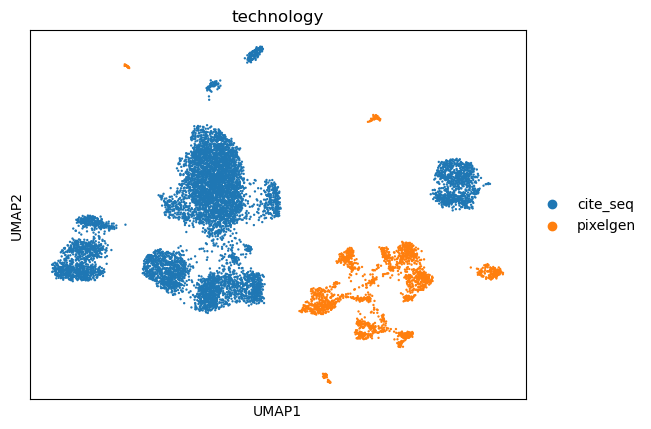

In [5]:
# subset on bb markers
bb_markers = adata.var_names[(adata.var['_batch_0'] & adata.var['_batch_1'])]
adata_bb = adata[:, bb_markers].copy()

adata_bb.X = adata_bb.layers['scaled']
sc.tl.pca(adata_bb)
sc.pp.neighbors(adata_bb)
sc.tl.umap(adata_bb)
adata_bb.obsm['X_umap_unintegrated'] = adata_bb.obsm['X_umap']
sc.pl.umap(adata_bb, color='technology')

# Train cytoVI model

In [15]:
# train model
cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
model = cytovi.CytoVI(adata, protein_likelihood='normal')
model.train(batch_size=1024)

/tmp/ipykernel_33252/1445493445.py:2: UserWarning: Found nan_layer in adata. Will register nan_layer for missing marker imputation.
  cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 30 records. Best score: -185.268. Signaling Trainer to stop.


Text(0, 0.5, 'elbo_validation')

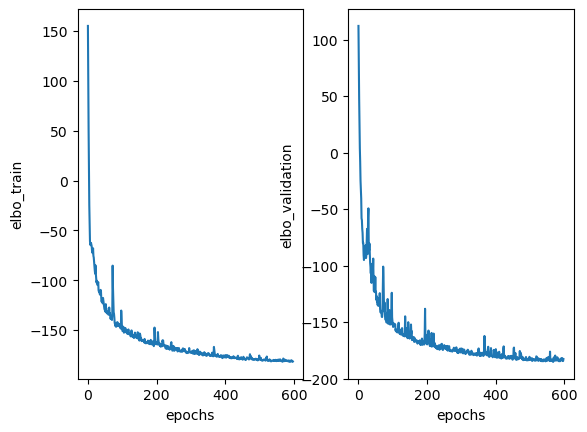

In [17]:
# check convergance
plt.subplot(1, 2, 1)
plt.plot(model.history['elbo_train'])
plt.xlabel('epochs')
plt.ylabel('elbo_train')

plt.subplot(1, 2, 2)
plt.plot(model.history['elbo_validation'])
plt.xlabel('epochs')
plt.ylabel('elbo_validation')

/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: detected missing proteins between batches - will impute missing markers
  return func(*args, **kwargs)


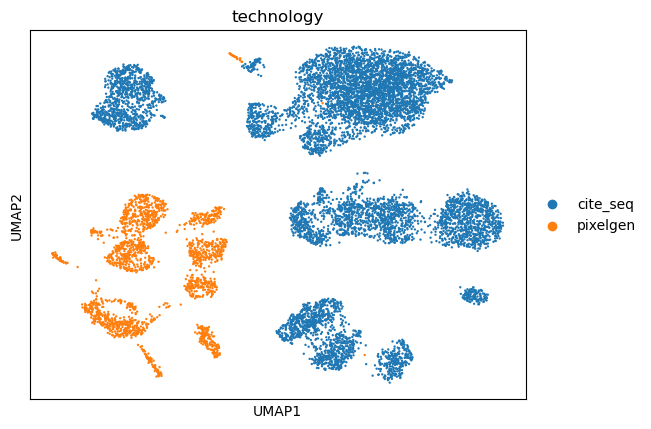

In [18]:
# get latent space
adata.obsm['X_CytoVI'] = model.get_latent_representation()

# impute missing markers
adata.layers['imputed_cross'] = model.get_normalized_expression(n_samples = 10)

sc.pp.neighbors(adata, use_rep='X_CytoVI')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['technology'])

/home/labs/amit/floriani/github_repos/CytoVI_dev/src/cytovi/pl/cyto_pl.py:73: UserWarning: Group pixelgen has less observations than 5000 observations.Taking all group observations. Set replace to True to sample with replacement.
  adata = subsample(adata, n_obs=n_obs, groupby=groupby)
/home/labs/amit/floriani/github_repos/CytoVI_dev/src/cytovi/pp/cyto_pp.py:295: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index = adata.obs.groupby(groupby, as_index=False).apply(


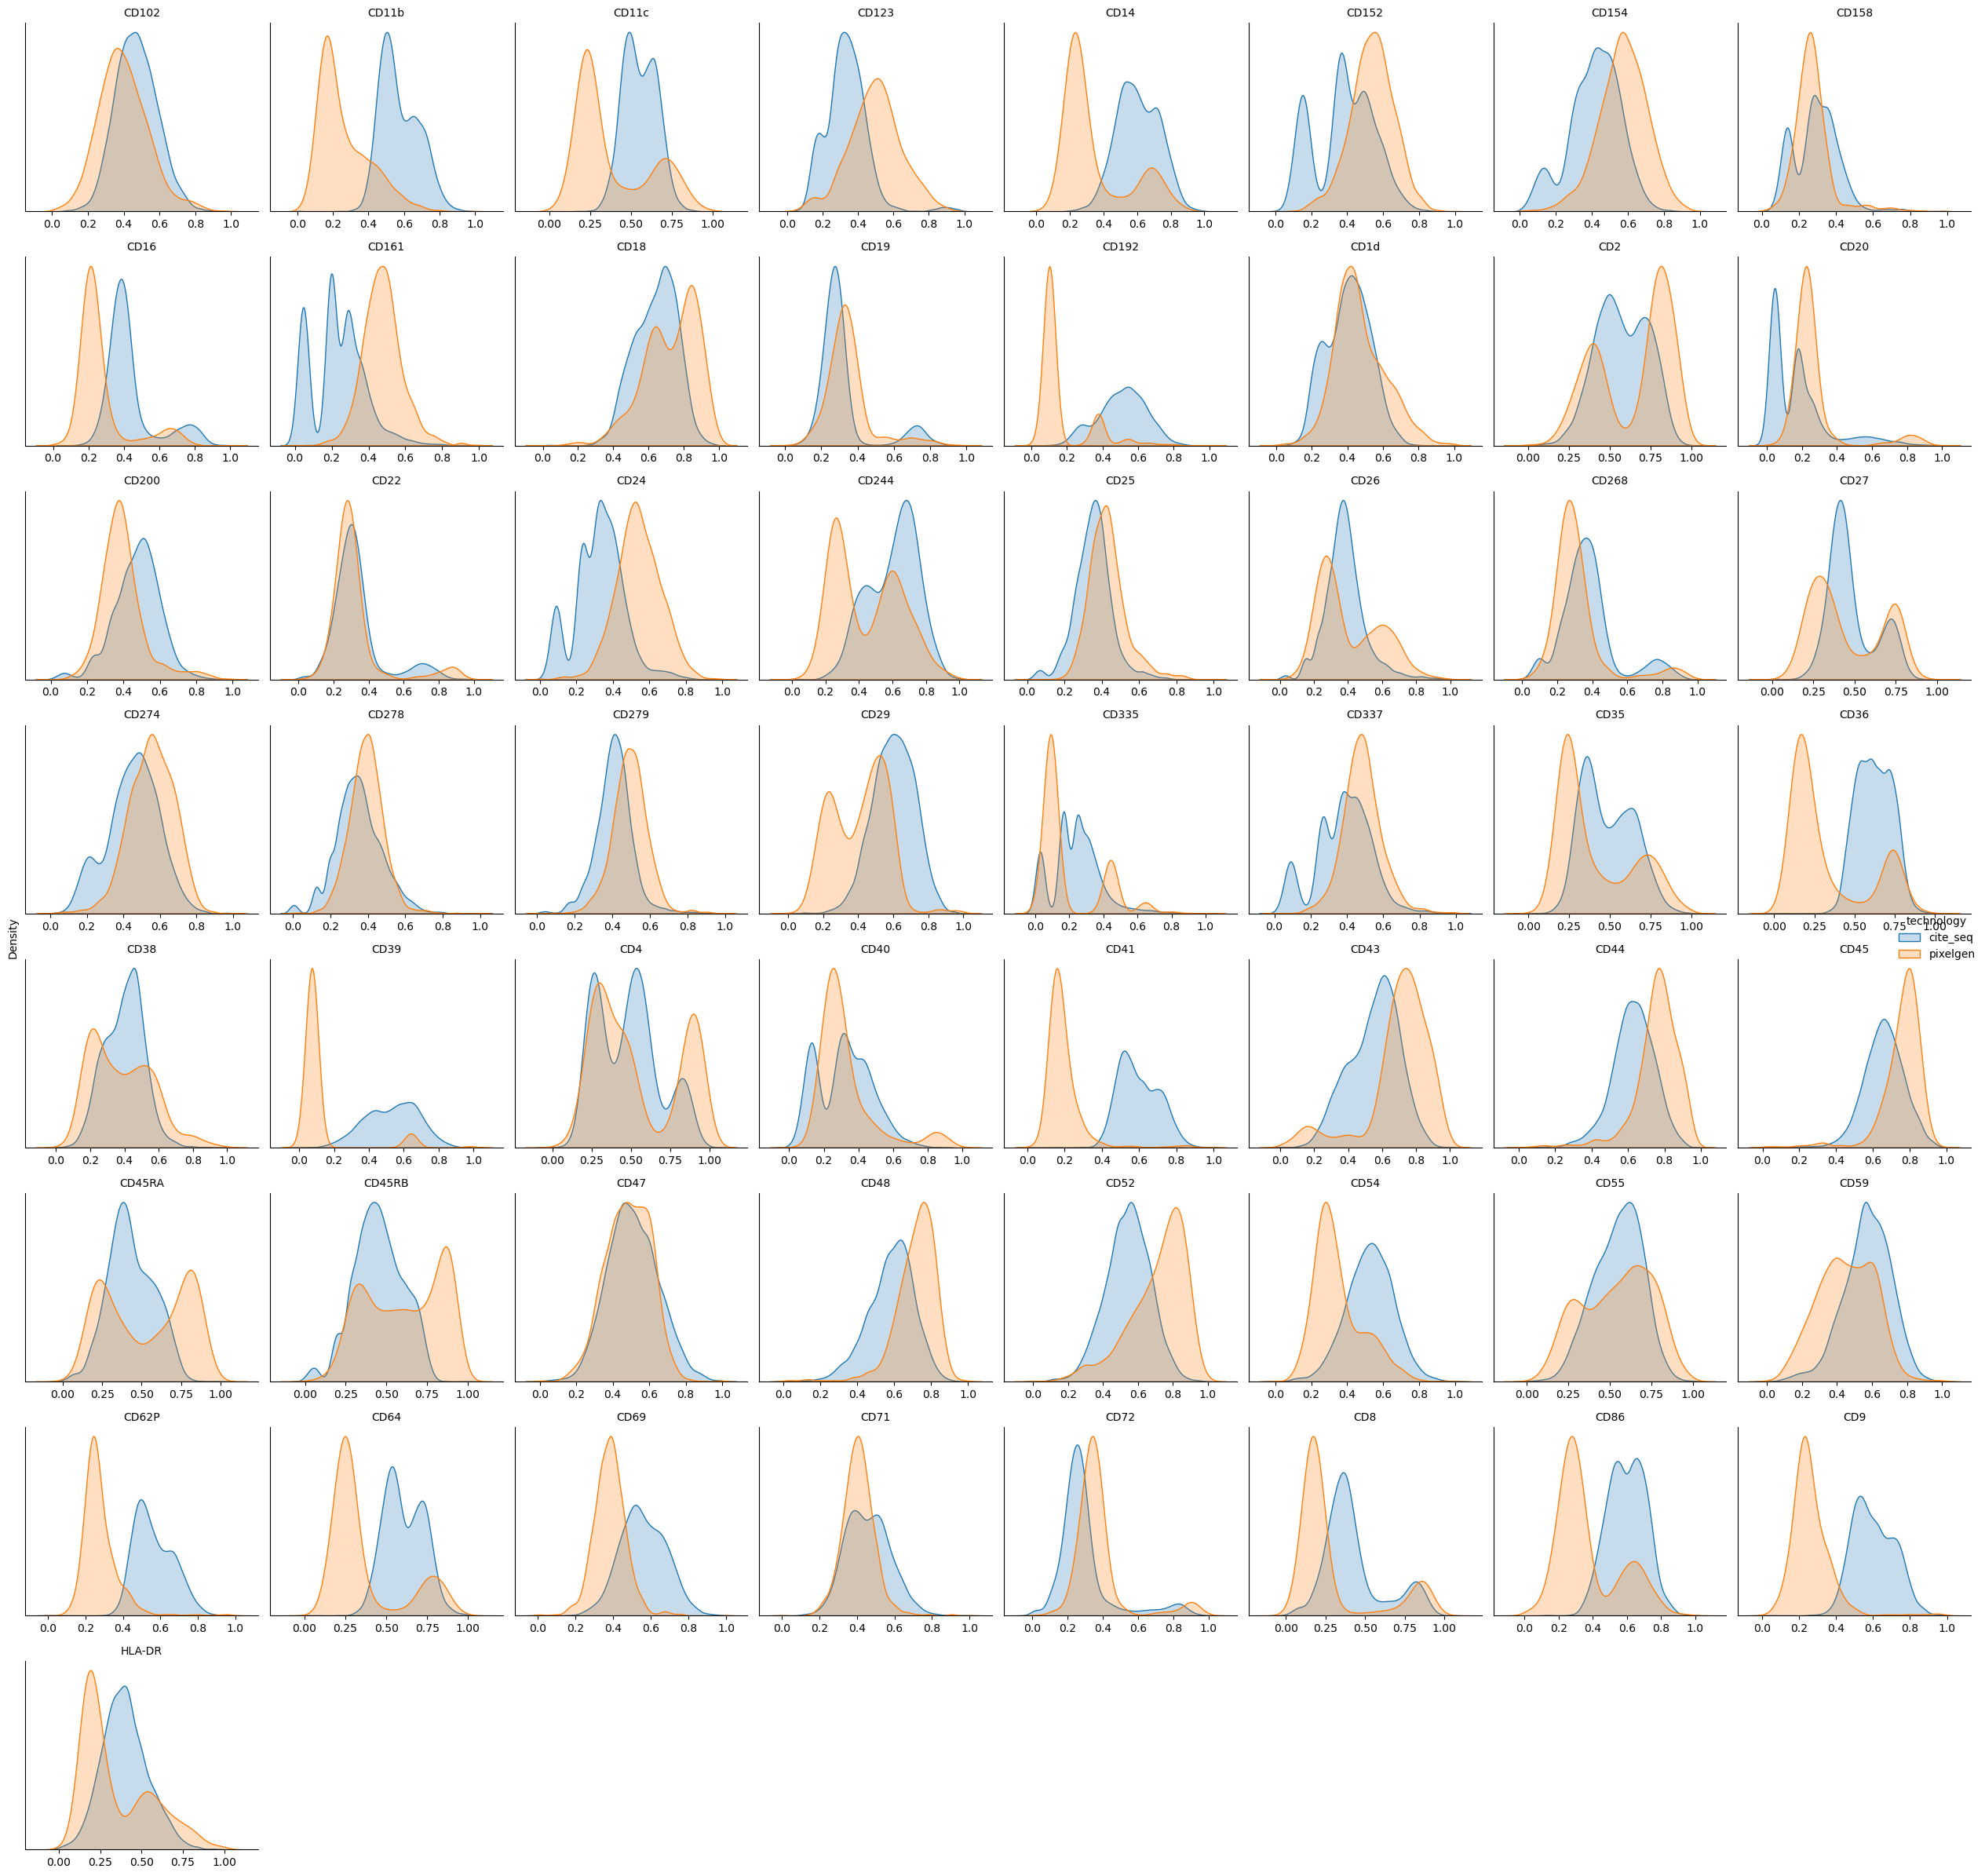

In [24]:
cytovi.pl.histogram(adata, marker = [*bb_markers], layer_key='scaled', groupby='technology')

# without mog

In [9]:
# train model
cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
model = cytovi.CytoVI(adata, protein_likelihood='normal', prior_mixture = False)
model.train(batch_size=1024)

/tmp/ipykernel_21369/4022220276.py:2: UserWarning: Found nan_layer in adata. Will register nan_layer for missing marker imputation.
  cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 30 records. Best score: -177.706. Signaling Trainer to stop.


Text(0, 0.5, 'elbo_validation')

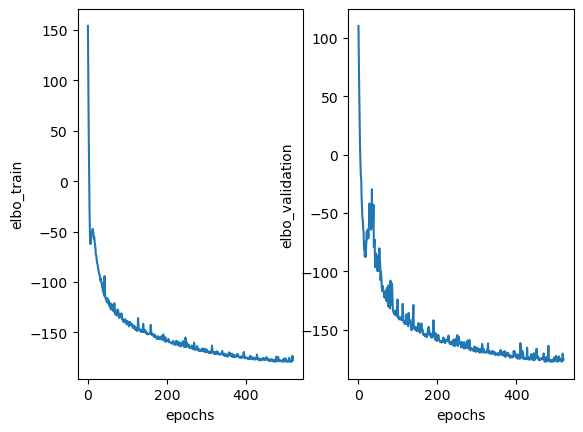

In [10]:
# check convergance
plt.subplot(1, 2, 1)
plt.plot(model.history['elbo_train'])
plt.xlabel('epochs')
plt.ylabel('elbo_train')

plt.subplot(1, 2, 2)
plt.plot(model.history['elbo_validation'])
plt.xlabel('epochs')
plt.ylabel('elbo_validation')

/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: detected missing proteins between batches - will impute missing markers
  return func(*args, **kwargs)


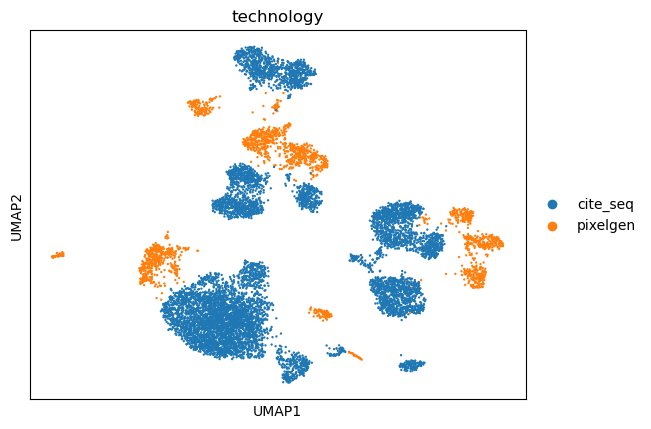

In [11]:
# get latent space
adata.obsm['X_CytoVI'] = model.get_latent_representation()

# impute missing markers
adata.layers['imputed_cross'] = model.get_normalized_expression(n_samples = 10)

sc.pp.neighbors(adata, use_rep='X_CytoVI')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['technology'])

# repeat but use arcsinh transformation

In [20]:
cytovi.pp.arcsinh(adata_pxl)
cytovi.pp.scale(adata_pxl)

cytovi.pp.arcsinh(adata_cite)
cytovi.pp.scale(adata_cite)

adata = cytovi.pp.merge_batches([adata_pxl, adata_cite])

/tmp/ipykernel_36552/236129756.py:7: UserWarning: Not all proteins are detected across all batches. Will generate nan_layer for imputation of missing proteins. 
Backbone markers: CD102, CD11b, CD11c, CD123, CD14, CD152, CD154, CD158, CD16, CD161, CD18, CD19, CD192, CD1d, CD2, CD20, CD200, CD22, CD24, CD244, CD25, CD26, CD268, CD27, CD274, CD278, CD279, CD29, CD335, CD337, CD35, CD36, CD38, CD39, CD4, CD40, CD41, CD43, CD44, CD45, CD45RA, CD45RB, CD47, CD48, CD52, CD54, CD55, CD59, CD62P, CD64, CD69, CD71, CD72, CD8, CD86, CD9, HLA-DR
  adata = cytovi.pp.merge_batches([adata_pxl, adata_cite])


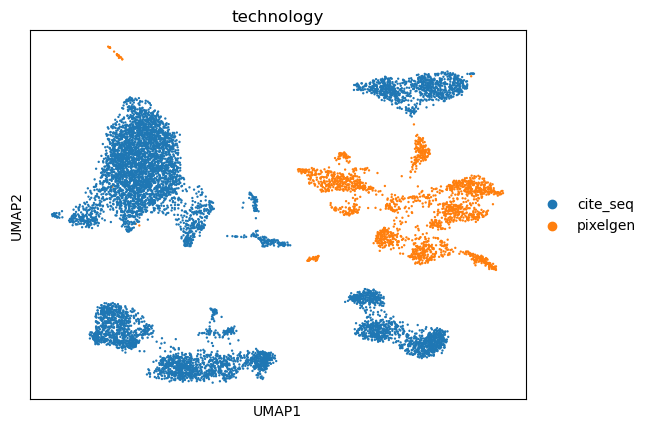

In [26]:
# subset on bb markers
bb_markers = adata.var_names[(adata.var['_batch_0'] & adata.var['_batch_1'])]
adata_bb = adata[:, bb_markers].copy()

adata_bb.X = adata_bb.layers['scaled']
sc.tl.pca(adata_bb)
sc.pp.neighbors(adata_bb)
sc.tl.umap(adata_bb)
adata_bb.obsm['X_umap_unintegrated'] = adata_bb.obsm['X_umap']
sc.pl.umap(adata_bb, color='technology')

In [27]:
# train model
cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
model = cytovi.CytoVI(adata, protein_likelihood='normal')
model.train(batch_size=1024)

/tmp/ipykernel_36552/1445493445.py:2: UserWarning: Found nan_layer in adata. Will register nan_layer for missing marker imputation.
  cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 30 records. Best score: -200.458. Signaling Trainer to stop.


Text(0, 0.5, 'elbo_validation')

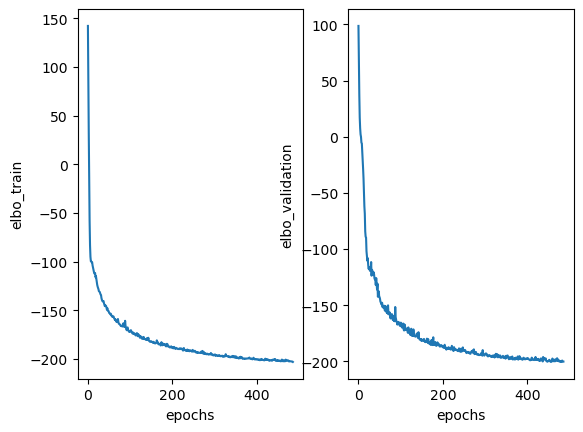

In [28]:
# check convergance
plt.subplot(1, 2, 1)
plt.plot(model.history['elbo_train'])
plt.xlabel('epochs')
plt.ylabel('elbo_train')

plt.subplot(1, 2, 2)
plt.plot(model.history['elbo_validation'])
plt.xlabel('epochs')
plt.ylabel('elbo_validation')

/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: detected missing proteins between batches - will impute missing markers
  return func(*args, **kwargs)


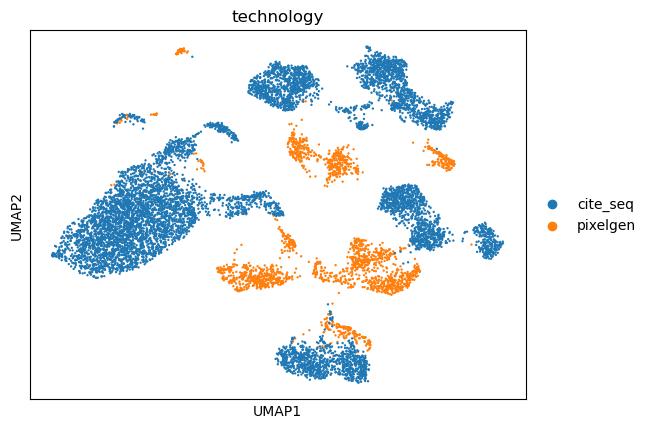

In [29]:
# get latent space
adata.obsm['X_CytoVI'] = model.get_latent_representation()

# impute missing markers
adata.layers['imputed_cross'] = model.get_normalized_expression(n_samples = 10)

sc.pp.neighbors(adata, use_rep='X_CytoVI')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['technology'])

# repeat without mog

In [30]:
# train model
cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
model = cytovi.CytoVI(adata, protein_likelihood='normal', prior_mixture=False)
model.train(batch_size=1024)

/tmp/ipykernel_36552/3434383147.py:2: UserWarning: Found nan_layer in adata. Will register nan_layer for missing marker imputation.
  cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 30 records. Best score: -203.848. Signaling Trainer to stop.


Text(0, 0.5, 'elbo_validation')

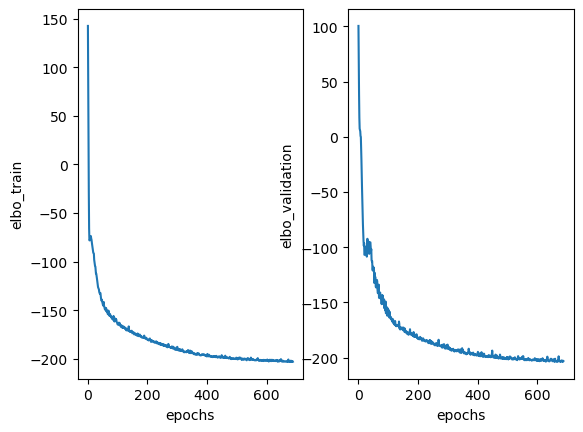

In [33]:
# check convergance
plt.subplot(1, 2, 1)
plt.plot(model.history['elbo_train'])
plt.xlabel('epochs')
plt.ylabel('elbo_train')

plt.subplot(1, 2, 2)
plt.plot(model.history['elbo_validation'])
plt.xlabel('epochs')
plt.ylabel('elbo_validation')

In [31]:
adata_pxl

AnnData object with n_obs × n_vars = 2029 × 84
    obs: 'pixels', 'a_pixels', 'b_pixels', 'antibodies', 'molecules', 'reads', 'mean_reads_per_molecule', 'median_reads_per_molecule', 'mean_b_pixels_per_a_pixel', 'median_b_pixels_per_a_pixel', 'mean_a_pixels_per_b_pixel', 'median_a_pixels_per_b_pixel', 'a_pixel_b_pixel_ratio', 'mean_molecules_per_a_pixel', 'median_molecules_per_a_pixel', 'leiden', 'tau_type', 'tau', 'sample', 'technology'
    var: 'antibody_count', 'components', 'antibody_pct', 'nuclear', 'control', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_umap', 'pca'
    layers: 'dsb', 'log1p', 'raw', 'scaled_dsb', 'transformed', 'scaled'
    obsp: 'connectivities', 'distances'

In [32]:
adata_cite

AnnData object with n_obs × n_vars = 8430 × 217
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size', 'technology'
    layers: 'dsb', 'raw', 'scaled', 'transformed'

/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: detected missing proteins between batches - will impute missing markers
  return func(*args, **kwargs)


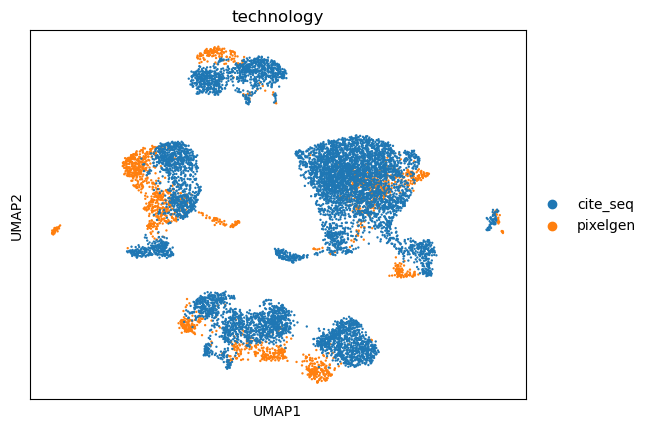

In [34]:
# get latent space
adata.obsm['X_CytoVI'] = model.get_latent_representation()

# impute missing markers
adata.layers['imputed_cross'] = model.get_normalized_expression(n_samples = 10)

sc.pp.neighbors(adata, use_rep='X_CytoVI')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['technology'])

# isotropic gaussian + adv scale

In [35]:
# train model
cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
model = cytovi.CytoVI(adata, protein_likelihood='normal', prior_mixture=False)
model.train(batch_size=1024, plan_kwargs={'scale_adversarial_loss': 2})

/tmp/ipykernel_36552/938045238.py:2: UserWarning: Found nan_layer in adata. Will register nan_layer for missing marker imputation.
  cytovi.CytoVI.setup_anndata(adata, layer='scaled', batch_key='batch')
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.
/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 30 records. Best score: -204.257. Signaling Trainer to stop.


Text(0, 0.5, 'elbo_validation')

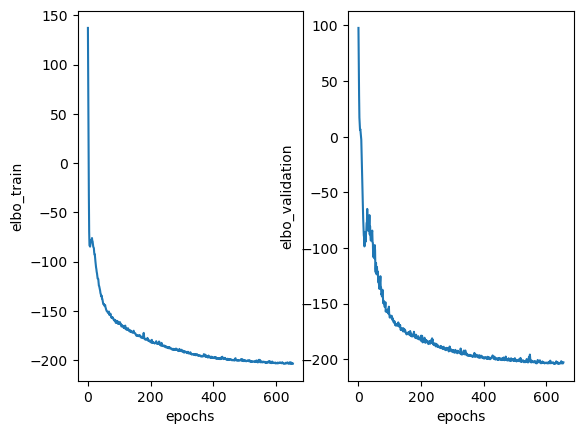

In [36]:
# check convergance
plt.subplot(1, 2, 1)
plt.plot(model.history['elbo_train'])
plt.xlabel('epochs')
plt.ylabel('elbo_train')

plt.subplot(1, 2, 2)
plt.plot(model.history['elbo_validation'])
plt.xlabel('epochs')
plt.ylabel('elbo_validation')

/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: detected missing proteins between batches - will impute missing markers
  return func(*args, **kwargs)


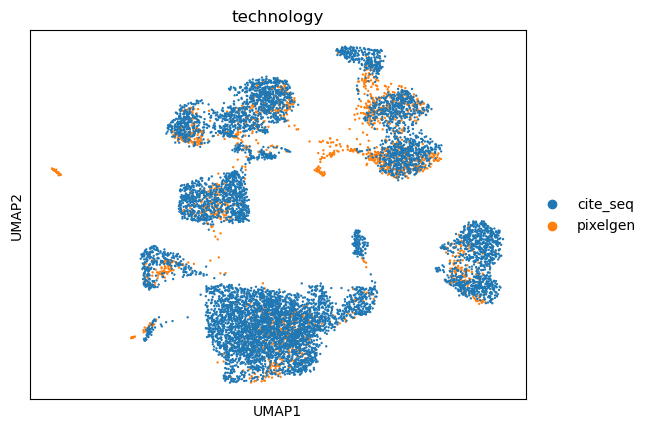

In [37]:
# get latent space
adata.obsm['X_CytoVI'] = model.get_latent_representation()

# impute missing markers
adata.layers['imputed_cross'] = model.get_normalized_expression(n_samples = 10)

sc.pp.neighbors(adata, use_rep='X_CytoVI')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['technology'])

In [39]:
adata.obs

,pixels,a_pixels,b_pixels,antibodies,molecules,reads,mean_reads_per_molecule,median_reads_per_molecule,mean_b_pixels_per_a_pixel,median_b_pixels_per_a_pixel,...,total_counts,total_counts_mt,pct_counts_mt,Protein log library size,Number proteins detected,RNA log library size,batch,_scvi_batch,_scvi_labels,_scvi_sample_id
RCVCMP0000000_Sample5,5833.0,3749.0,2084.0,79.0,35040.0,114108.0,3.256507,3.0,2.794345,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
RCVCMP0000001_Sample5,4769.0,3338.0,1431.0,79.0,33399.0,107689.0,3.224318,3.0,2.933493,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
RCVCMP0000002_Sample5,4227.0,2724.0,1503.0,78.0,34376.0,113349.0,3.297330,3.0,3.825624,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
RCVCMP0000004_Sample5,3285.0,2159.0,1126.0,79.0,13859.0,42368.0,3.057075,3.0,2.352478,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
RCVCMP0000005_Sample5,9958.0,6413.0,3545.0,79.0,43839.0,136302.0,3.109149,3.0,2.397318,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_TTTGATCAGGACAACC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6409.0,465.0,7.255422,7.875499,183.0,8.765458,1,1,0,0
E2L8_TTTGATCCAGCCTACG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12549.0,813.0,6.478604,9.355392,208.0,9.437396,1,1,0,0
E2L8_TTTGATCCATTCCTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13165.0,1006.0,7.641473,8.543640,200.0,9.485317,1,1,0,0
E2L8_TTTGATCGTGATCATC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8833.0,554.0,6.271935,9.217813,210.0,9.086250,1,1,0,0


In [42]:
[*adata.var_names[~adata.var['_batch_0'] & adata.var['_batch_1']]]

['B7-H4',
 'C5L2',
 'CCR10',
 'CD103',
 'CD105',
 'CD106',
 'CD107a',
 'CD109',
 'CD110',
 'CD112',
 'CD115',
 'CD117',
 'CD119',
 'CD11a/CD18',
 'CD122',
 'CD124',
 'CD126',
 'CD127',
 'CD13',
 'CD133',
 'CD134',
 'CD135',
 'CD137',
 'CD138',
 'CD140a',
 'CD140b',
 'CD141',
 'CD142',
 'CD144',
 'CD146',
 'CD15',
 'CD155',
 'CD158b',
 'CD158e1',
 'CD158f',
 'CD163',
 'CD164',
 'CD169',
 'CD171',
 'CD172a',
 'CD177',
 'CD178',
 'CD184',
 'CD185',
 'CD186',
 'CD193',
 'CD194',
 'CD195',
 'CD196',
 'CD199',
 'CD1a',
 'CD1c',
 'CD201',
 'CD202b',
 'CD203c',
 'CD204',
 'CD205',
 'CD206',
 'CD207',
 'CD209',
 'CD21',
 'CD223',
 'CD226',
 'CD235a',
 'CD235ab',
 'CD243',
 'CD252',
 'CD253',
 'CD267',
 'CD269',
 'CD270',
 'CD271',
 'CD272',
 'CD273',
 'CD275',
 'CD28',
 'CD284',
 'CD294',
 'CD3',
 'CD30',
 'CD301',
 'CD303',
 'CD304',
 'CD305',
 'CD307c/FcRL3',
 'CD307d',
 'CD307e',
 'CD309',
 'CD31',
 'CD314',
 'CD319',
 'CD324',
 'CD325',
 'CD338',
 'CD34',
 'CD340',
 'CD354',
 'CD357',
 'CD3

In [45]:
adata.var.loc[['CD3', 'CD4', 'CD8', 'CD19', 'CD14', 'CD56'], :]

,_batch_0,_batch_1
CD3,False,True
CD4,True,True
CD8,True,True
CD19,True,True
CD14,True,True
CD56,False,True


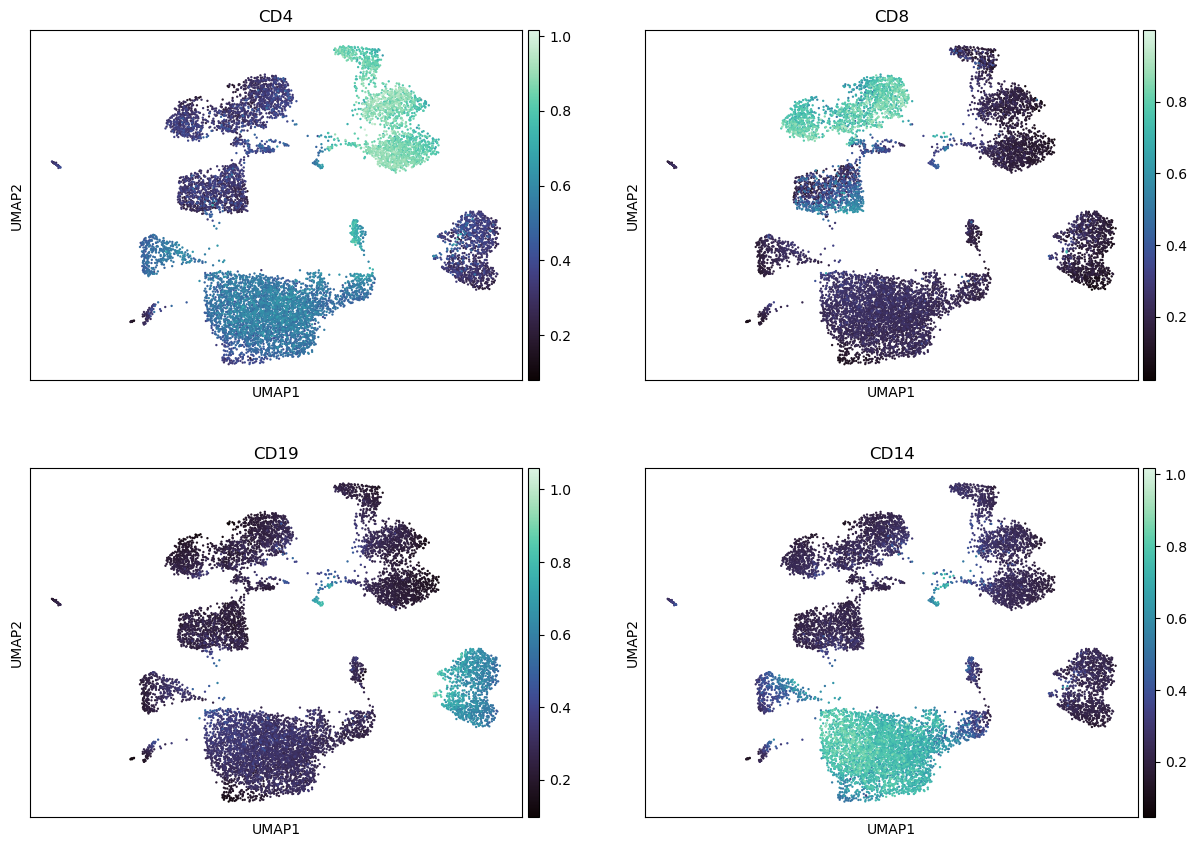

In [49]:
sc.pl.umap(adata, color=['CD4', 'CD8', 'CD19', 'CD14'], layer='imputed_cross', cmap='mako', ncols=2)

In [1]:
sc.pl.umap(adata, color=['CD56', 'IgM', 'CD1c', 'XCR1'], layer='imputed_cross', cmap='mako', ncols=2)

NameError: name 'sc' is not defined